In [1]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from functools import reduce
import random
import math
import matplotlib.pyplot as plt
import pickle
import pandas as pd

## 금융 데이터를 yfinance로부터 받아오기

In [2]:
import yfinance as yf
import datetime

def get_stocks_datas(ticker_names: list[str], start_date, end_date):
    # WARN: returns는 prices보다 길이가 1 작다.
    prices = {}
    returns = {}
    for name in ticker_names:
        data = yf.Ticker(name)
        data = data.history(start=start_date, end=end_date, interval="1d")
        prices[name] = data['Close']
        returns[name] = data['Close'].pct_change()[1:]
    return prices, returns

start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2017, 12, 31)
stock_prices, stock_returns = get_stocks_datas(["AAPL", "MSFT"], start_date, end_date)


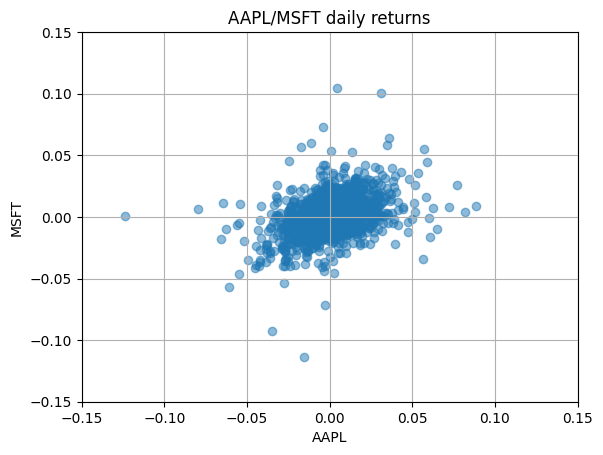

In [3]:
# 산점도 그리기
plt.scatter(stock_returns["AAPL"].values, stock_returns["MSFT"].values, alpha=0.5)
plt.title(f'AAPL/MSFT daily returns')
plt.xlabel('AAPL')
plt.ylabel('MSFT')
plt.xlim(-0.15, 0.15)
plt.ylim(-0.15, 0.15)
plt.grid(True)
plt.show()

## copula 변환/역변환 준비

역변환은 기존 분포를 normal distribution이라 가정

In [4]:
from scipy.stats import norm
import random

def probability_integral_transform(x, y):
    assert len(x) == len(y)
    n = len(x)
    x_sorted = sorted([(x, i) for i, x in enumerate(x)])
    y_sorted = sorted([(y, i) for i, y in enumerate(y)])
    xx = np.zeros(n)
    yy = np.zeros(n)

    for i in tqdm(range(n)):
        xx[x_sorted[i][1]] = i / n
        yy[y_sorted[i][1]] = i / n
        
    return xx, yy

def reverse_probability_integral_transform(x, y, x_mean, x_std, y_mean, y_std):
    assert(len(x) == len(y))
    n = len(x)
    xx = []
    yy = []
    for i in range(n):
        # 정규분포에서 면적이 x[i] 가 되는 z값
        xx.append(norm.ppf(x[i], loc=x_mean, scale=x_std))
        yy.append(norm.ppf(y[i], loc=y_mean, scale=y_std))
    return xx, yy

  0%|          | 0/2012 [00:00<?, ?it/s]

100%|██████████| 2012/2012 [00:00<00:00, 3025794.07it/s]


Text(0.5, 1.0, 'Copula space plot')

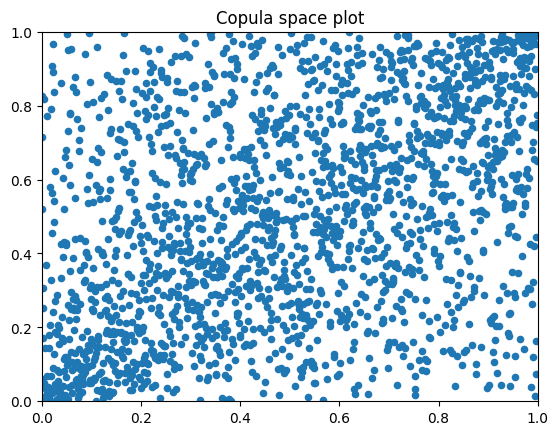

In [5]:
copula_x, copula_y = probability_integral_transform(stock_returns["AAPL"].values, stock_returns["MSFT"].values)
plt.scatter(copula_x, copula_y, s=20)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Copula space plot')

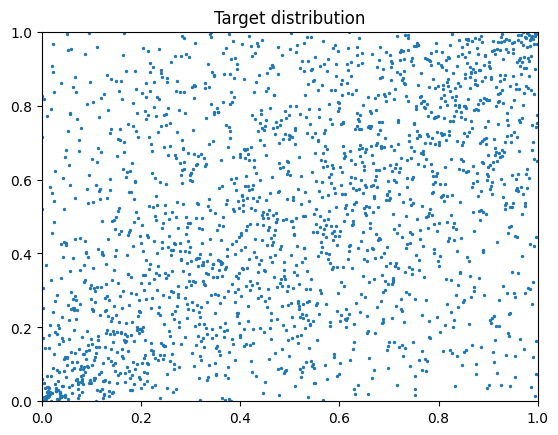

In [10]:
target_distribution = np.column_stack((copula_x, copula_y))
plt.scatter(target_distribution[:,0], target_distribution[:,1], s=2.0)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Target distribution')
plt.show()

In [20]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [21]:
noise_qubits = 6
code_qubits = 1
n_qubits = noise_qubits + code_qubits

n_layers = 1
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

BATCH_SIZE = 2048
MINIBATCH_SIZE = 16

dev = qml.device("default.qubit", wires=n_qubits, shots=1) # 제너레이터 돌려서 값 뽑아내는데 쓰임. 이중 몇개 골라서 판별자도 학습함.

n_qubits = 7 n_layers = 1


In [ ]:
coeff = 0.2

def generator_init(generator_input):
    for i in range(noise_qubits):
        qml.Hadamard(wires=i)
    for i in range(noise_qubits//2):
        qml.CNOT(wires=[i, i+noise_qubits//2])

def generator_layer(params):
    for i in range(n_qubits):
        qml.RZ(params[i][0], wires=i)
        qml.RX(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])
        qml.RX(params[i][3], wires=i)
        qml.CNOT(wires=[i, (i+2)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    generator_init(generator_input)
    for param in params:
        generator_layer(param)
    return qml.sample(wires=range(n_qubits))


def generator_forward(params, generator_input):
    generator_output = [generator_circuit(params, single_in) for single_in in generator_input]
    values = []
    for output in generator_output:
        gen_x = 0
        gen_y = 0
        for i in range(noise_qubits//2):
            gen_x += (0.5**(i+1)) * output[i]
        for i in range(noise_qubits//2, noise_qubits):
            gen_y += (0.5**(i-noise_qubits//2+1)) * output[i]
        gen_x += random.randint(0, (2**20)-1) / (2**23)
        gen_y += random.randint(0, (2**20)-1) / (2**23)
        values.append([gen_x, gen_y])
    generator_output = torch.tensor(values) # (-1, 2) 차원
    return generator_output


def generator_cost_fn(params, generator_input, use_mine = False, _qmine = False):
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (-1, code_qubits)

    generator_output = generator_forward(params, generator_input) # 출력을 뽑아낸다
    generator_output = generator_output.to(torch.float32) # (-1, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = -torch.log(disc_output).mean()
    
    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(len(code_input))]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi

    elif _qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return gan_loss

In [29]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=2):
        super().__init__()
        self.hidden_size = 100
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)
        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 32
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(2, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    if smoothing:
        real_label = real_label - 0.2*torch.rand(real_label.shape).to(device)
    #print("진짜입력", real_input, "가짜입력", fake_input)
    #print("disc debug하자","real = ", disc_real.mean().item(), disc_real.std().item(), "fake = ", disc_fake.mean().item(), disc_fake.std().item())
    #print("항별 값 = ", torch.log(disc_real).mean() , torch.log(1.0 - disc_fake).mean())
    loss = -0.5 * (torch.log(disc_real).mean() + torch.log(1.0 - disc_fake).mean())
    
    return loss

## custom spsa optimizer

구현 오류 제보 환영

In [30]:
class SPSA_opt():
    def __init__(self, a=0.008, c=0.01, n_iter = 5, gamma=0.101):
        self.epoch = 1
        self.a = a
        self.c = c
        self.n_iter = n_iter
        self.gamma = gamma

    def step(self):
        self.epoch += 1
    
    def get_params(self):
        # (a, c) tuple return
        return self.a/self.epoch, self.c/(self.epoch**self.gamma)

def spsa_step(params):
    # 한 iter당 n_iter * 2 * MINIBATCH_SIZE 만큼 순회함
    # 기본값 = 5 * 2 * 16 = 160
    # return값: 평균 loss
    loss_sum = 0
    spsa_opt = SPSA_opt()
    for i in range(spsa_opt.n_iter):
        a, c = spsa_opt.get_params()
        delta = np.random.choice([-1, 1], size=params.shape)
        z = np.random.uniform(-1, 1, (MINIBATCH_SIZE, n_qubits))

        loss_plus = generator_cost_fn(params + c * delta, z) # 실제론 shot=MINIBATCH_SIZE
        loss_plus = loss_plus.detach().numpy()
        loss_minus = generator_cost_fn(params - c * delta, z) # 실제론 shot=MINIBATCH_SIZE
        loss_minus = loss_minus.detach().numpy()

        g = (loss_plus - loss_minus)/(2*c*delta)
        # print('param = ', params[0], 'delta =', (a*g)[0], 'aft =', (params-a*g)[0])
        params -= a*g
        loss_sum = loss_sum + (loss_plus + loss_minus)/2
        spsa_opt.step()
    
    return params, loss_sum / spsa_opt.n_iter

In [31]:
generator_params = Variable(torch.tensor(np.random.uniform(0, 2*np.pi, (n_layers, n_qubits, 4))))
print("parameter shape: ", generator_params.shape)

discriminator = LinearDiscriminator()
mine = LinearMine()

D_lr = 0.0015
M_lr = 1e-4
use_mine = False
use_qmine = False
D_opt = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
M_opt = torch.optim.Adam(mine.parameters(), lr=M_lr)

D_scheduler = torch.optim.lr_scheduler.StepLR(D_opt, step_size=30, gamma=0.85)
M_scheduler = torch.optim.lr_scheduler.StepLR(M_opt, step_size=30, gamma=0.7)

parameter shape:  torch.Size([1, 7, 4])


In [32]:
import os
title = f'spsa14_{use_mine}'
if not os.path.exists(f'result/{title}'):
    os.makedirs(f'result/{title}')
    
with open(f'result/{title}/param.txt', 'w') as f:
    f.write('D_lr = {}\n'.format(D_lr))
    f.write('M_lr = {}\n'.format(M_lr))
    f.write('D_scheduler: step={}, gamma={}\n'.format(D_scheduler.step_size, D_scheduler.gamma))
    f.write('M_scheduler: step={}, gamma={}\n'.format(M_scheduler.step_size, M_scheduler.gamma))
    f.write('coeff = {}\n'.format(coeff))
    f.write('use_mine = {}\n'.format(use_mine))
    f.write('use_qmine = {}\n'.format(use_qmine))
    f.write('n_qubits = {}\n'.format(n_qubits))
    f.write('noise_qubits = {}\n'.format(noise_qubits))
    f.write('code_qubits = {}\n'.format(code_qubits))
    f.write('n_layers = {}\n'.format(n_layers))
    f.write('param shape = {}\n'.format(generator_params.shape))

In [33]:
def visualize_output(gen_outputs, gen_codes, title, rep, recorder):
    plt.figure(figsize=(10 + 4 * code_qubits, 7))  # 전체 그림의 크기 지정
    
    plt.subplot(2, 2 + code_qubits, 1)
    plt.title('Target distribution')
    plt.scatter(stock_returns["AAPL"].values, stock_returns["MSFT"], s=10,  alpha=0.2)
    plt.xlim((-0.2, 0.2))
    plt.ylim((-0.2, 0.2))
    plt.grid()

    # 역변환
    rev_x, rev_y = reverse_probability_integral_transform(gen_outputs[:,0], gen_outputs[:,1],
                                                      stock_returns["AAPL"].mean(), stock_returns["AAPL"].std(),
                                                      stock_returns["MSFT"].mean(), stock_returns["MSFT"].std())
    
    print(np.corrcoef(rev_x, gen_outputs[:,1])[0,1])
    plt.subplot(2, 2 + code_qubits, 2)
    plt.title('Epoch {0}'.format(rep))
    plt.scatter(rev_x, rev_y, s=10,  alpha=0.2)
    plt.xlim((-0.2, 0.2))
    plt.ylim((-0.2, 0.2))
    plt.grid()

    for i in range(code_qubits):
        plt.subplot(2, 2 + code_qubits, 3 + i)
        plt.title('Epoch {0} code {1}'.format(rep, i))
        plt.scatter(rev_x, rev_y, s=10, c=gen_codes[:, i], cmap='RdYlBu', alpha=0.2)
        plt.xlim((-0.2, 0.2))
        plt.ylim((-0.2, 0.2))
        plt.colorbar()  # 색상 막대 추가
        plt.grid()
    
    
    plt.subplot(2, 2 + code_qubits, 3 + code_qubits)
    plt.title('Target copula'.format(rep))
    plt.scatter(copula_x, copula_y, s=10,  alpha=0.2)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.grid()

    plt.subplot(2, 2 + code_qubits, 4 + code_qubits)
    plt.title('Epoch {0} copula'.format(rep))
    plt.scatter(gen_outputs[:, 0], gen_outputs[:, 1], s=10,  alpha=0.2)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.grid()

    for i in range(code_qubits):
        plt.subplot(2, 2 + code_qubits, 5 + code_qubits + i)
        plt.title('Epoch {0} code {1}'.format(rep, i))
        plt.scatter(gen_outputs[:, 0], gen_outputs[:, 1], s=10, c=gen_codes[:, i], cmap='RdYlBu', alpha=0.2)
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.colorbar()  # 색상 막대 추가
        plt.grid()

    plt.savefig(f'result/{title}/{rep}.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} code-axis corr'.format(rep))
    for i in range(code_qubits):
        plt.plot(recorder[f'code{i}-x'], label=f'code{i}-x', marker='o')
        plt.plot(recorder[f'code{i}-y'], label=f'code{i}-y', marker='o')
        plt.plot(recorder[f'mi'], label='mi', marker='o')
        plt.plot(recorder[f'd_loss'], label='d_loss', marker='o')
        plt.plot(recorder[f'g_loss'], label='g_loss', marker='o')

    plt.xlabel('epoch')
    plt.ylabel('correlation')
    plt.ylim(-1, 1)
    plt.title(f'code - axis corr graph (rep={rep})')
    plt.legend()
    plt.savefig(f'result/{title}/corr_{rep}.png', dpi=300)
    plt.show()

100%|██████████| 125/125 [00:00<00:00, 284.91it/s, D_loss=0.161, MI=-.0147]


epoch: 1, D_loss: 0.16123169529624284, G_loss: 0.0002928255766164511, MI = -0.01471902485191822
좌표값 평균 =  0.47975725 0.5407697
corr =  0.0069193277139754285 진짜 corr =  0.4073921204453951
-0.003637414448079706


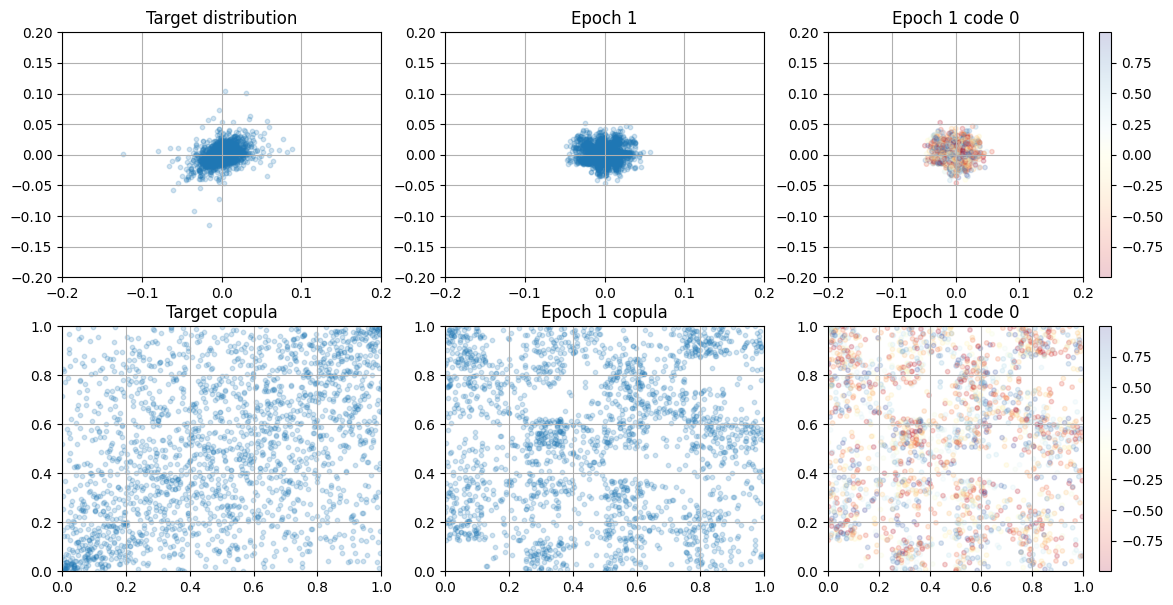

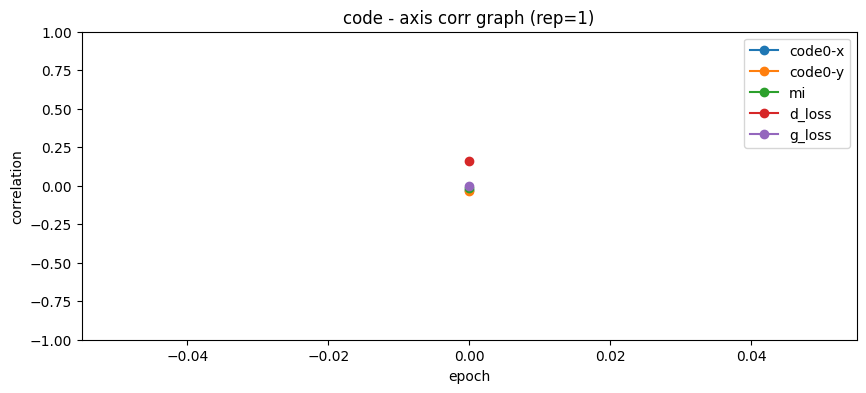

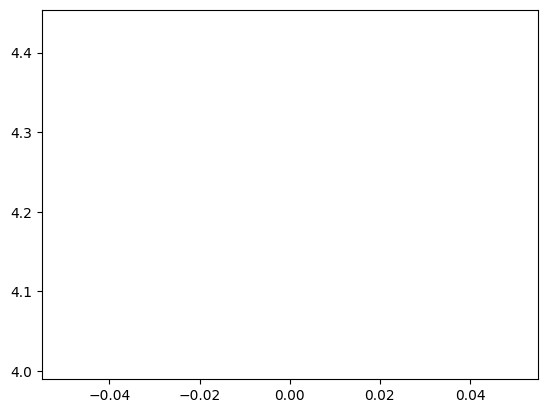

In [34]:
epoch = 300

recorder_keywords = ['d_loss', 'g_loss', 'mi', 'corr']
for i in range(code_qubits):
    recorder_keywords.append(f'code{i}-x')
    recorder_keywords.append(f'code{i}-y')

recorder = {k: [] for k in recorder_keywords}
final_rep = 0

c_target = np.corrcoef(target_distribution[:,0], target_distribution[:,1])[0,1]

x_recorder = []

for rep in range(1, epoch+1):
    np.random.shuffle(target_distribution)
    iter_num = int(min(BATCH_SIZE,len(target_distribution))  // MINIBATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.
    #iter_num = 16
    generator_seeds = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1 # seed = (2048, n_qubits)
    gen_outputs = generator_forward(generator_params, generator_seeds).detach() # 2048번 돌아간다

    D_loss_sum = 0.0
    mi_sum = 0.0
    log_gen_outputs = []
    log_gen_codes = []
    
    pbar = tqdm(range(iter_num))
    gen_rev_x, gen_rev_y = reverse_probability_integral_transform(gen_outputs[:, 0], gen_outputs[:, 1],
                                                      stock_returns["AAPL"].mean(), stock_returns["AAPL"].std(),
                                                      stock_returns["MSFT"].mean(), stock_returns["MSFT"].std())
    gen_rev = torch.FloatTensor(np.column_stack((gen_rev_x, gen_rev_y)))
    gen_rev.to(device)
    
    for i in pbar:
        x_indices = np.random.choice(len(target_distribution), size=MINIBATCH_SIZE)
        batch = torch.FloatTensor(target_distribution[x_indices])

        fake_input = gen_rev[MINIBATCH_SIZE * i : MINIBATCH_SIZE * i + MINIBATCH_SIZE]
        generator_seed = generator_seeds[MINIBATCH_SIZE * i : MINIBATCH_SIZE * i + MINIBATCH_SIZE]

        # train discriminator
        disc_loss = disc_cost_fn(batch, fake_input, smoothing=False)
        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train mine
        code_input = generator_seed[:, -code_qubits:] 
        pred_xy = mine(code_input, fake_input)
        code_input_shuffle = code_input[torch.randperm(len(code_input))]
        pred_x_y = mine(code_input_shuffle, fake_input)
        mi = -torch.mean(pred_xy) + torch.log(torch.mean(torch.exp(pred_x_y)))
        M_opt.zero_grad()
        mi.requires_grad_(True)
        mi.backward()
        M_opt.step()

        D_loss_sum += disc_loss.item()
        mi_sum -= mi.item() # (-1)곱해져 있어서 빼야함.

        pbar.set_postfix({'D_loss': D_loss_sum/(i+1), 'MI': mi_sum/(i+1)})
        log_gen_outputs.append(fake_input.numpy())
        log_gen_codes.append(code_input.numpy())

    # train generator
    generator_params, G_loss = spsa_step(generator_params)
    D_scheduler.step()
    M_scheduler.step()

    recorder['d_loss'].append(D_loss_sum/iter_num)
    recorder['g_loss'].append(G_loss)
    recorder['mi'].append(mi_sum/iter_num)
    
    gen_outputs = gen_outputs.numpy()
    print("epoch: {}, D_loss: {}, G_loss: {}, MI = {}".format(rep, D_loss_sum/iter_num, G_loss, mi_sum/iter_num))
    print("좌표값 평균 = ", np.mean(gen_outputs[:,0]), np.mean(gen_outputs[:,1]))

    c_gen = np.corrcoef(gen_outputs[:,0], gen_outputs[:,1])[0,1]
    print("corr = ", c_gen, "진짜 corr = ", c_target)
    recorder['corr'].append(c_gen)
    
    df = pd.DataFrame({'x': gen_outputs[:, 0], 'y': gen_outputs[:, 1]})
    for i in range(code_qubits):
        df[f'code{i}']=generator_seeds[:, i]
    corr_mat = df.corr().to_numpy()
    for i in range(code_qubits):
        recorder[f'code{i}-x'].append(corr_mat[0, i+2])
        recorder[f'code{i}-y'].append(corr_mat[1, i+2])
    
    visualize_output(gen_outputs, generator_seeds, title, rep, recorder)
    x_recorder.append(generator_params[0][0][0].item())
    plt.plot(x_recorder)
    plt.show()

    if rep % 10 == 0:
        with open(f'result/{title}/discriminator_{rep}.pkl', 'wb') as file:
            pickle.dump(discriminator, file)
        with open(f'result/{title}/generator_{rep}.pkl', 'wb') as file:
            pickle.dump(generator_params, file)

    final_rep = rep

In [ ]:
gen_outputs[:,0].mean()

## 모든 지표 엑셀파일로 저장

In [ ]:
import openpyxl
df = pd.DataFrame(recorder)
output_filename = f'result/{title}/recorder.xlsx'
df.to_excel(output_filesname, index=False)

## 최종 결과 plot

In [ ]:
inputs = []
outputs = []

for i in tqdm(range(5000)):
    with torch.no_grad():
        z = np.random.uniform(-1, 1, (1, n_qubits, 1))
        code_input = z[:, -code_qubits:].reshape(code_qubits) # 입력 z중에서 code를 추출한다.
        generator_output = generator_forward(generator_params, z, copula=output_copula)
        generator_output = generator_output.cpu().numpy().reshape(2)
        outputs.append(generator_output)
        inputs.append(code_input)

inputs = np.array(inputs).reshape(-1, code_qubits)

for code_ind in range(code_qubits):
    outputs = np.array(outputs)
    plt.scatter(outputs[:, 0], outputs[:, 1], c=inputs[:, code_ind], cmap='RdYlBu', alpha=0.2)
    plt.colorbar()  # 색상 막대 추가
    plt.title(f'code{code_ind}-distribution (rep = {final_rep})')
    plt.savefig(f'result/{title}/code_{code_ind}_{final_rep}.png')
    plt.show()

In [ ]:
outputs = np.array(outputs)[:len(x)]
plt.scatter(outputs[:, 0], outputs[:, 1], s=17, alpha=0.1)
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.show()

In [ ]:
pd.DataFrame({'x': outputs[:,0], 'y': outputs[:,1]}).corr()

In [ ]:
outputs = np.array(outputs)
plt.scatter(x[:, 0], x[:, 1], s=17, alpha=0.1)
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.show()
pd.DataFrame({'x': x[:,0], 'y': x[:,1]}).corr()